In [39]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from data.data_handler import SimpleDataset
from trainer import Trainer
from models.layers import MVN, Latent, ST, Normal
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
sns.set_style("whitegrid")
from torch.utils.data import Dataset, DataLoader

In [5]:
use_cuda =False# torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [6]:
data_dir = "data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")
df = stocks.copy().set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan

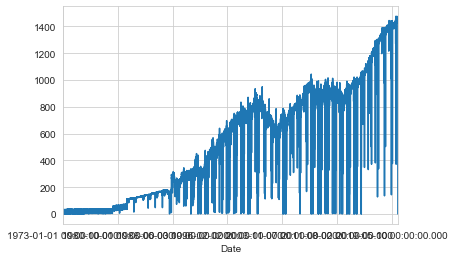

In [37]:
stocks.set_index(["Date", "Isin"]).unstack()["Close"].count(axis=1).plot()

In [7]:
T = 61
n_x = 10

scaler = StandardScaler()

X = []
y = []
t_list = []
t_dict = {}
steps = len(df) // T
windows = 100

def make_one_hot(labels, C = 5):
    y = torch.eye(C) 
    return y[labels.long()].squeeze(1)

def calc_y(y):
    ret = y.iloc[-1]/y.iloc[0] - 1
    std = y.pct_change().std()*np.sqrt(252)
    #print(ret, std)
    if ret > 0.15:
        return 0
    elif ret <= 0.15 and ret > 0.05:
        return 1
    elif ret <= 0.05 and ret > -0.05:
        return 2
    elif ret <= -0.05 and ret > -0.15:
        return 3
    elif ret <= -0.15:
        return 4

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].dropna(axis=1, thresh = 55).fillna(0.0)
    t_dict[t] = (df_t.index[0], df_t.index[-1])
    if df_t.shape[1] < n_x:
        continue
    for _ in range(windows):
        t_list.append([t])
        i = np.random.choice(np.arange(df_t.shape[1]), n_x, replace=False)
        df_t_i = df_t.iloc[:,i]
        X.append(df_t_i.values.reshape(-1,1).squeeze())
    
    

X = np.array(X)

t_arr = np.array(t_list)
X.shape, t_arr.shape

((8400, 610), (8400, 1))

In [48]:

X_train, X_test, t_train, t_test = train_test_split(X, t_arr, test_size = 0.2, random_state = 42)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
#y_scaler = StandardScaler()
#y_train  = y_scaler.fit_transform(y_train)
#y_test = y_scaler.transform(y_test)

In [56]:
class Markov(nn.Module):
    def __init__(self, steps, windows, T, n_x, n_z, batch_size):
        super().__init__()
        self.steps = steps
        self.windows = windows
        self.T = T
        self.n_x = n_x
        self.n_z = n_z
        self.batch_size = batch_size
        
        self.enc = nn.Sequential(
            Latent(T*n_x + n_z, n_z)
        )
        self.dec = nn.Sequential(
            Normal(n_z, T*n_x)
        )
        self.prior = nn.Sequential(
            Latent(n_z, n_z)
        )
        
        
    def _dkl_loss(self, prior_mean, prior_log_var, z_mean, z_log_var):
        z_var = z_log_var.exp()
        prior_var = prior_log_var.exp()
        kld = torch.sum(prior_log_var - z_log_var + ((z_var + (z_mean - prior_mean).pow(2)) / (prior_var*2)) - 0.5, dim=1)
        return kld
    
    def encode(self, x, z_prev):
        z_t, mu, log_var = self.enc(torch.cat([x, z_prev], 1))
        return z_t, mu, log_var
    
    def decode(self, z):
        return self.dec(z)
    
    def forward(self, x, t, beta = 1.0):
        z_prev = self.z[:,t-1,:]
        prior, prior_mu, prior_log_var = self.prior(z_prev)
        z_t, mu, log_var = self.encode(x, t)
        self.z[:, t, :] = z_t
        dkl = self._dkl_loss(prior_mu, prior_log_var, mu, log_var)
        dist = self.decode(z_t)
        rcl = -dist.log_var(x).sum(dim=1)
        return dist, torch.mean(rcl + beta*dkl)
    
    def fit(self, epochs, train_data, test_data):
        bs = train_data.batch_size
        

In [57]:
x = torch.randn(32, T*n_x)
t = torch.Tensor([1]*32).unsqueeze(1)
tau = 81
bs = 32
n_z = 2
vae = Markov(steps, windows,T, n_x, n_z, bs)

In [58]:
class MarkovData(Dataset):
    def __init__(self, X, t, shuffle=True):
        self.X = X
        self.t = t
        assert len(X) == len(t)
        self.batch_size = 32
        self.loader = DataLoader(self, batch_size=self.batch_size, shuffle=shuffle)
    
    def __len__(self):
        return len(X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx].float(), self.t[idx].float(), idx

In [49]:
train_data = MarkovData(X_train, t_train)
test_data = MarkovData(X_test, t_test)